<a href="https://colab.research.google.com/github/4nchez/Colab-Jupiter/blob/master/Kmean%2C%20Kmedois%2C%20hierachical%2C%20DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 첫번째 K-mean(https://m.blog.naver.com/wideeyed/221534602937)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# IRIS 꽃 데이터를 읽고 순서를 섞는다
iris_df = sns.load_dataset('iris').sample(frac=1).reset_index(drop=True)
iris_df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.5,2.4,3.7,1.0,versicolor
1,4.6,3.1,1.5,0.2,setosa
2,5.8,2.8,5.1,2.4,virginica


In [ ]:
# 사용할 X컬럼들과 Y컬럼을 지정한다
x_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
y_column  = 'species'

# Y컬럼의 문자열값을 LabelEncoder를 통해 숫자로 바꾼다.
y_true_label_encoder = preprocessing.LabelEncoder()
y_true_encoded       = y_true_label_encoder.fit_transform(iris_df[y_column])
print(list(iris_df[y_column][:3]), '->' ,list(y_true_encoded[:3]))

['versicolor', 'setosa', 'virginica'] -> [1, 0, 2]


In [ ]:
kMeansModels              = dict() # k값별 모델 저장할 딕셔너리
kMeansModelPreds          = dict() # k값별 모델 예측 결과 저장할 딕셔너리
kMeansModelLabelEncoder   = dict() # k값별 라벨인코더 저장할 딕셔너리
# kMeansCenter   = dict() # k값별 라벨인코더 저장할 딕셔너리

sumSquaredDistancesList   = list() # 샘플과 클러스터 센터간 거리 제곱의 합 리스트
silhouetteScoreList       = list() # Silhouette Coefficient 평균 리스트

ks = [2,3,4,5,6,7,8,9] # k값으로 2부터 9까지 테스트한다
for k in ks: # k값 순회
    model = KMeans(n_clusters=k, random_state=0, n_init=100)  # k개 클러스터로 모델 생성
    cluster_labels = model.fit_predict(iris_df[x_columns]) # X컬럼으로 지정된 필드값으로 피팅
    
    y_pred_label_encoder = preprocessing.LabelEncoder() # 예측한 클러스터에서 사용할 라벨인코더
    # 초기 임의 값 (unknown 1, unknown 2...) 으로 인코딩한다
    y_pred_label_encoder.fit(np.array(['unknown ' + str(i+1) for i in range(0, k, 1)], dtype=object))
    for pred_label_num in range(0,k,1): # 각 클러스터 순회        
        # 해당 클러스터에서 가장 많이 출력한 실제 값의 인덱스를 구한다
        most_frequent_index = np.argmax(np.bincount(y_true_encoded[cluster_labels==pred_label_num]))
        # 구한 인덱스의 라벨을 구해서 해당클러스터 라벨로 업데이트한다
        y_pred_label_encoder.classes_[pred_label_num] = y_true_label_encoder.classes_[most_frequent_index]
    
    kMeansModels[k]     = model                       # 모델 저장
    kMeansModelPreds[k] = cluster_labels              # 모델 예측결과 저장     
    kMeansModelLabelEncoder[k] = y_pred_label_encoder # 라벨인코더 저장
    # kMeansCenter[k] = model.cluster_centers_
    kMeansCenter = pd.DataFrame(model.cluster_centers_)
    sumSquaredDistancesList.append(model.inertia_)    # # 샘플과 클러스터 센터간 거리 제곱의 합 저장
    silhouetteScoreList.append(silhouette_score(iris_df[x_columns].values, cluster_labels)) # Silhouette Score저장

In [ ]:
kMeansCenter.columns=x_columns
kMeansCenter

,sepal_length,sepal_width,petal_length,petal_width
0,6.568182,3.086364,5.536364,2.163636
1,5.100000,3.513043,1.526087,0.273913
2,5.628571,2.723810,4.133333,1.295238
3,7.475000,3.125000,6.300000,2.050000
4,6.442105,2.978947,4.594737,1.431579
5,5.242857,2.371429,3.442857,1.028571
6,4.678947,3.084211,1.378947,0.200000
7,6.036842,2.705263,5.000000,1.778947
8,5.512500,4.000000,1.475000,0.275000


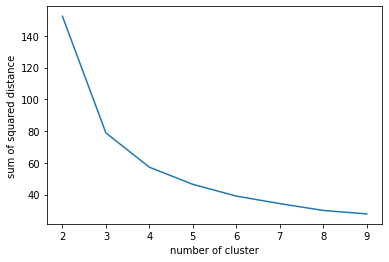

In [ ]:
plt.plot(ks, sumSquaredDistancesList)
plt.xlabel("number of cluster")
plt.ylabel("sum of squared distance")
plt.show()

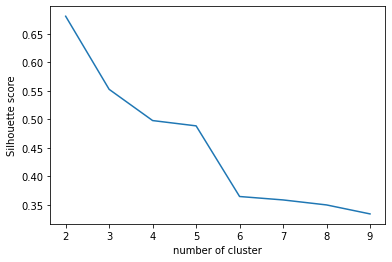

In [ ]:
plt.plot(ks, silhouetteScoreList)
plt.xlabel("number of cluster")
plt.ylabel("Silhouette score")
plt.show()

In [ ]:
def render_plot(x_col='petal_length', y_col='petal_width', k=3):
    y_pred        = kMeansModelPreds[k]        # 모델 예측값
    label_encoder = kMeansModelLabelEncoder[k] # 라벨인코더
    center = kMeansCenter
    # 원본과 예측값을 합쳐 데이터셋을 준비
    mdf = pd.concat([iris_df, pd.DataFrame(label_encoder.inverse_transform(y_pred), columns=[y_column+'_pred'])], axis=1)
    
    plt.figure(figsize=(15,8)) # 출력 크기를 지정
    
    ddf = mdf[mdf[y_column] != mdf[y_column+'_pred']] # 실제라벨과 예측라벨이 틀린 경우 추출
    # X기호로 error임을 표시한다
    plt.scatter(x=ddf[x_col], y=ddf[y_col], c='black', marker='x', s=300, label='error') 
    
    colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black'] # 컬러값 리스트
    for (idx,cls) in enumerate(list(y_true_label_encoder.classes_)):
        ddf = mdf[mdf[y_column] == cls] # 실제라벨 데이터는 작은 점으로 출력
        plt.scatter(x=ddf[x_col], y=ddf[y_col], c=colors[idx], marker='.', linewidths=3, s=50, label=cls)
        ddf = mdf[mdf[y_column+'_pred'] == cls] # 예측라벨 데이터는 큰 원으로 출력
        plt.scatter(x=ddf[x_col], y=ddf[y_col], c=colors[idx], marker='o', linewidths=13, s=2, label=cls+' pred')
    y_s=['setosa','versicolor', 'virginica']
    for i in range(k):
      plt.scatter(center[x_col][i],center[y_col][i], s=60,marker='D',c='black', label=' center')
    # target = iris.target
    # species = np.chararray(target.shape, itemsize=150)
    # for i in range(len(iris_df)):
    #   if target[i] == 0:
    #     species[i] = 'setosa'
    #   elif target[i] == 1:
    #     species[i] = 'versicolor'
    #   elif target[i] == 2:
    #     species[i] = 'virginica'
    # df = pd.DataFrame({'labels': y_pred, 'species': species})
    # ct = pd.crosstab(df['labels'], df['species'])
    # print(ct)
    
    
    plt.legend();plt.xlabel(x_col);plt.ylabel(y_col)
    print('accuracy {:.2f}'.format(np.mean(mdf[y_column] == mdf[y_column+'_pred']))) # 정확도 출력
    plt.show()

In [ ]:
interact(render_plot, x_col=x_columns, y_col=x_columns, k=ks)

interactive(children=(Dropdown(description='x_col', index=2, options=('sepal_length', 'sepal_width', 'petal_le…

<function __main__.render_plot>

# 두번째 K-mean, K-medois(https://eunsukimme.github.io/ml/2019/12/16/K-Means/)

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
samples = iris.data

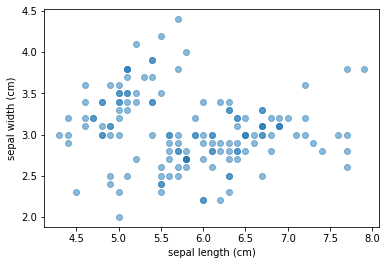

In [ ]:
from matplotlib import pyplot as plt
x = samples[:, 0]
y = samples[:, 1]
plt.scatter(x, y, alpha=0.5)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [ ]:
import numpy as np
k = 3
# 랜덤으로 x, y 좌표 3개를 생성합니다
# np.random.uniform은 주어진 최소, 최대값 사이에서 k 개 만큼 실수 난수를 생성합니다.
centroids_x = np.random.uniform(min(x), max(x), k)
centroids_y = np.random.uniform(min(y), max(y), k)
centroids = list(zip(centroids_x, centroids_y))

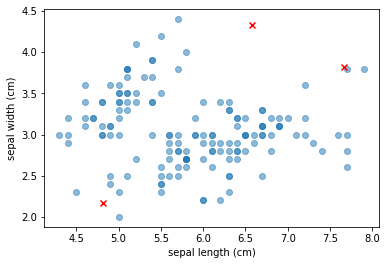

In [ ]:
plt.scatter(x, y, alpha=0.5)	# 데이터들은 파란색으로 표시되고
plt.scatter(centroids_x, centroids_y,marker='x',c='red')	# centroids는 주황색으로 표시됩니다
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [ ]:
def distance(a, b):
    return sum([(el_a - el_b)**2 for el_a, el_b in list(zip(a, b))]) ** 0.5

In [ ]:
# 각 데이터 포인트를 그룹화 할 labels을 생성합니다 (0, 1, 또는 2)
labels = np.zeros(len(samples))
sepal_length_width = np.array(list(zip(x, y)))
# 각 데이터를 순회하면서 centroids와의 거리를 측정합니다
for i in range(len(samples)):
  distances = np.zeros(k)	# 초기 거리는 모두 0으로 초기화 해줍니다
  for j in range(k):
    distances[j] = distance(sepal_length_width[i], centroids[j])
  cluster = np.argmin(distances)	# np.argmin은 가장 작은 값의 index를 반환합니다
  labels[i] = cluster

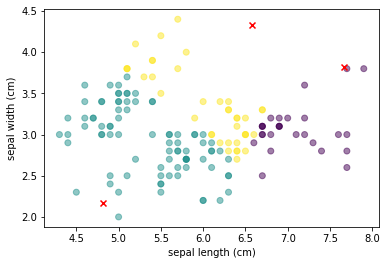

In [ ]:
plt.scatter(x, y, c=labels, alpha=0.5)
plt.scatter(centroids_x, centroids_y, c='red', label='center',marker='x')	# centroid는 빨간색으로 나타냅니다
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [ ]:
from copy import deepcopy
centroids_old = deepcopy(centroids)

In [ ]:
for i in range(k):
  # 각 그룹에 속한 데이터들만 골라 points에 저장합니다
  points = [ sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i ]
  # points의 각 feature, 즉 각 좌표의 평균 지점을 centroid로 지정합니다
  centroids[i] = np.mean(points, axis=0)

In [ ]:
import pandas as pd
centroids_old1 = pd.DataFrame(centroids_old)
centroids1 = pd.DataFrame(centroids)

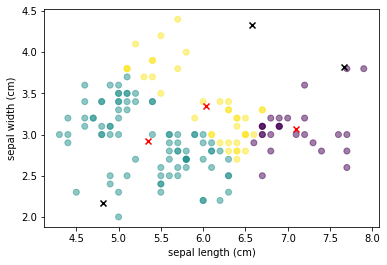

In [ ]:
plt.scatter(x, y, c=labels, alpha=0.5)
plt.scatter(centroids_old1[0], centroids_old1[1], c='black', marker='x')
plt.scatter(centroids1[0], centroids1[1], c='red', marker='x')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

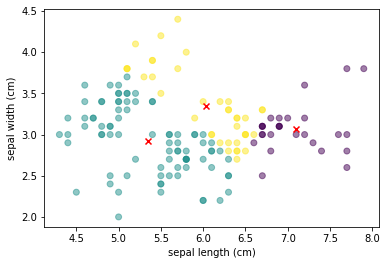

In [ ]:
plt.scatter(x, y, c=labels, alpha=0.5)
plt.scatter(centroids1[0], centroids1[1], c='red', marker='x')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [ ]:
# STEP 2: 가까운 centroids에 데이터를 할당합니다
# 각 데이터 포인트를 그룹화 할 labels을 생성합니다 (0, 1, 또는 2)
labels = np.zeros(len(samples))
# 각 데이터를 순회하면서 centroids와의 거리를 측정합니다
for i in range(len(samples)):
  distances = np.zeros(k)	# 초기 거리는 모두 0으로 초기화 해줍니다
  for j in range(k):
    distances[j] = distance(sepal_length_width[i], centroids[j])
  cluster = np.argmin(distances)	# np.argmin은 가장 작은 값의 index를 반환합니다
  labels[i] = cluster
# Step 3: centroids를 업데이트 시켜줍니다
centroids_old = deepcopy(centroids)
for i in range(k):
  # 각 그룹에 속한 데이터들만 골라 points에 저장합니다
  points = [ sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i ]
  # points의 각 feature, 즉 각 좌표의 평균 지점을 centroid로 지정합니다
  centroids[i] = np.mean(points, axis=0)

In [ ]:
centroids1 = pd.DataFrame(centroids_old)
centroids2 = pd.DataFrame(centroids)

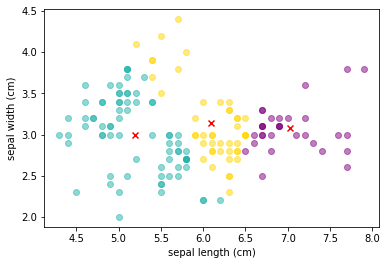

In [ ]:
colors = ['purple','lightseagreen','gold']
for i in range(k):
    points = np.array([sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i])
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.5)
# plt.scatter(centroids1[0], centroids1[1], c='black', marker='x')
plt.scatter(centroids2[0], centroids2[1], c='red', marker='x')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [ ]:
centroids_old = np.zeros(centroids1.shape)	# 제일 처음 centroids_old는 0으로 초기화 해줍니다
labels = np.zeros(len(samples))
error = np.zeros(k)
# error 도 초기화 해줍니다
for i in range(k):
  error[i] = distance(centroids_old[i], centroids[i])
# STEP 4: error가 0에 수렴할 때 까지 2 ~ 3 단계를 반복합니다
while(error.all() != 0):
  # STEP 2: 가까운 centroids에 데이터를 할당합니다
  for i in range(len(samples)):
    distances = np.zeros(k)	# 초기 거리는 모두 0으로 초기화 해줍니다
    for j in range(k):
      distances[j] = distance(sepal_length_width[i], centroids[j])
    cluster = np.argmin(distances)	# np.argmin은 가장 작은 값의 index를 반환합니다
    labels[i] = cluster
  # Step 3: centroids를 업데이트 시켜줍니다
  centroids_old = deepcopy(centroids)
  for i in range(k):
    # 각 그룹에 속한 데이터들만 골라 points에 저장합니다
    points = [ sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i ]
    # points의 각 feature, 즉 각 좌표의 평균 지점을 centroid로 지정합니다
    centroids[i] = np.mean(points, axis=0)
  # 새롭게 centroids를 업데이트 했으니 error를 다시 계산합니다
  for i in range(k):
    error[i] = distance(centroids_old[i], centroids[i])

In [ ]:
centroids1 = pd.DataFrame(centroids_old)
centroids2 = pd.DataFrame(centroids)

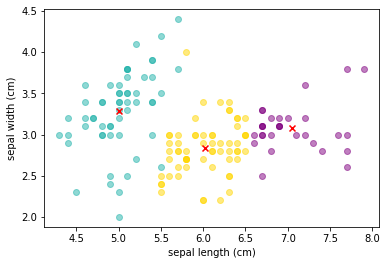

In [ ]:
colors = ['purple','lightseagreen','gold']
for i in range(k):
    points = np.array([sepal_length_width[j] for j in range(len(sepal_length_width)) if labels[j] == i])
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], alpha=0.5)
# plt.scatter(centroids1[0], centroids1[1], c='black', marker='x')
plt.scatter(centroids2[0], centroids2[1], c='red', marker='x')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [ ]:
target = iris.target
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
species = np.chararray(target.shape, itemsize=150)
for i in range(len(samples)):
  if target[i] == 0:
    species[i] = 'setosa'
  elif target[i] == 1:
    species[i] = 'versicolor'
  elif target[i] == 2:
    species[i] = 'virginica'

In [ ]:
import pandas as pd

df = pd.DataFrame({'labels': labels, 'species': species})
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

species  b'setosa'  b'versicolor'  b'virginica'
labels                                         
0.0             26             26             7
1.0              0             23            43
2.0             24              1             0


In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 624kB 2.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=340333 sha256=e2beb1e45489dace49ea5f9ac204b671b9a6bc5231780ed0546713c70018ae4d
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


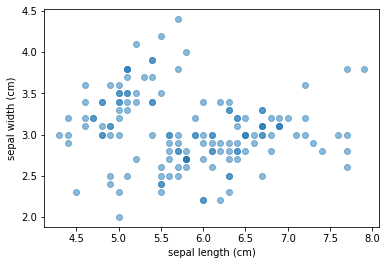

In [ ]:
iris = datasets.load_iris()
samples = iris.data
from matplotlib import pyplot as plt
x = samples[:, 0]
y = samples[:, 1]
plt.scatter(x, y, alpha=0.5)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

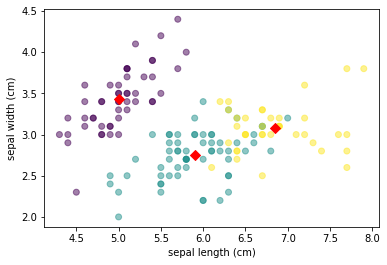

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
# from sklearn_extra.cluster import KMedoids
import pandas as pd
iris = datasets.load_iris()
samples = iris.data
# 3개의 그룹으로 나누는 K-Means, K-Medoids 모델을 생성합니다
model = KMeans(n_clusters = 3)
# model = KMedoids(n_clusters = 8)
model.fit(samples)
labels = model.predict(samples)
# 클러스터링 결과를 시각화합니다
x = samples[:, 0]
y = samples[:, 1]
plt.scatter(x, y, c=labels, alpha=0.5)
centers = pd.DataFrame(model.cluster_centers_)

# scatter plot
plt.scatter(centers[0],centers[1],s=50,marker='D',c='r')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.show()

In [ ]:
target = iris.target
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
species = np.chararray(target.shape, itemsize=150)
for i in range(len(samples)):
  if target[i] == 0:
    species[i] = 'setosa'
  elif target[i] == 1:
    species[i] = 'versicolor'
  elif target[i] == 2:
    species[i] = 'virginica'

In [ ]:
import pandas as pd

df = pd.DataFrame({'labels': labels, 'species': species})
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

species  b'setosa'  b'versicolor'  b'virginica'
labels                                         
0               50              0             0
1                0             48            14
2                0              2            36


# 세 번째 hierachical (hierarchy) https://bcho.tistory.com/1204| https://joyfuls.tistory.com/64

In [ ]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()

labels = pd.DataFrame(iris.target)
labels.columns=['labels']
data = pd.DataFrame(iris.data)
data.columns=['Sepal length','Sepal width','Petal length','Petal width']
data = pd.concat([data,labels],axis=1)

data.head()

,Sepal length,Sepal width,Petal length,Petal width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
labels

,labels
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


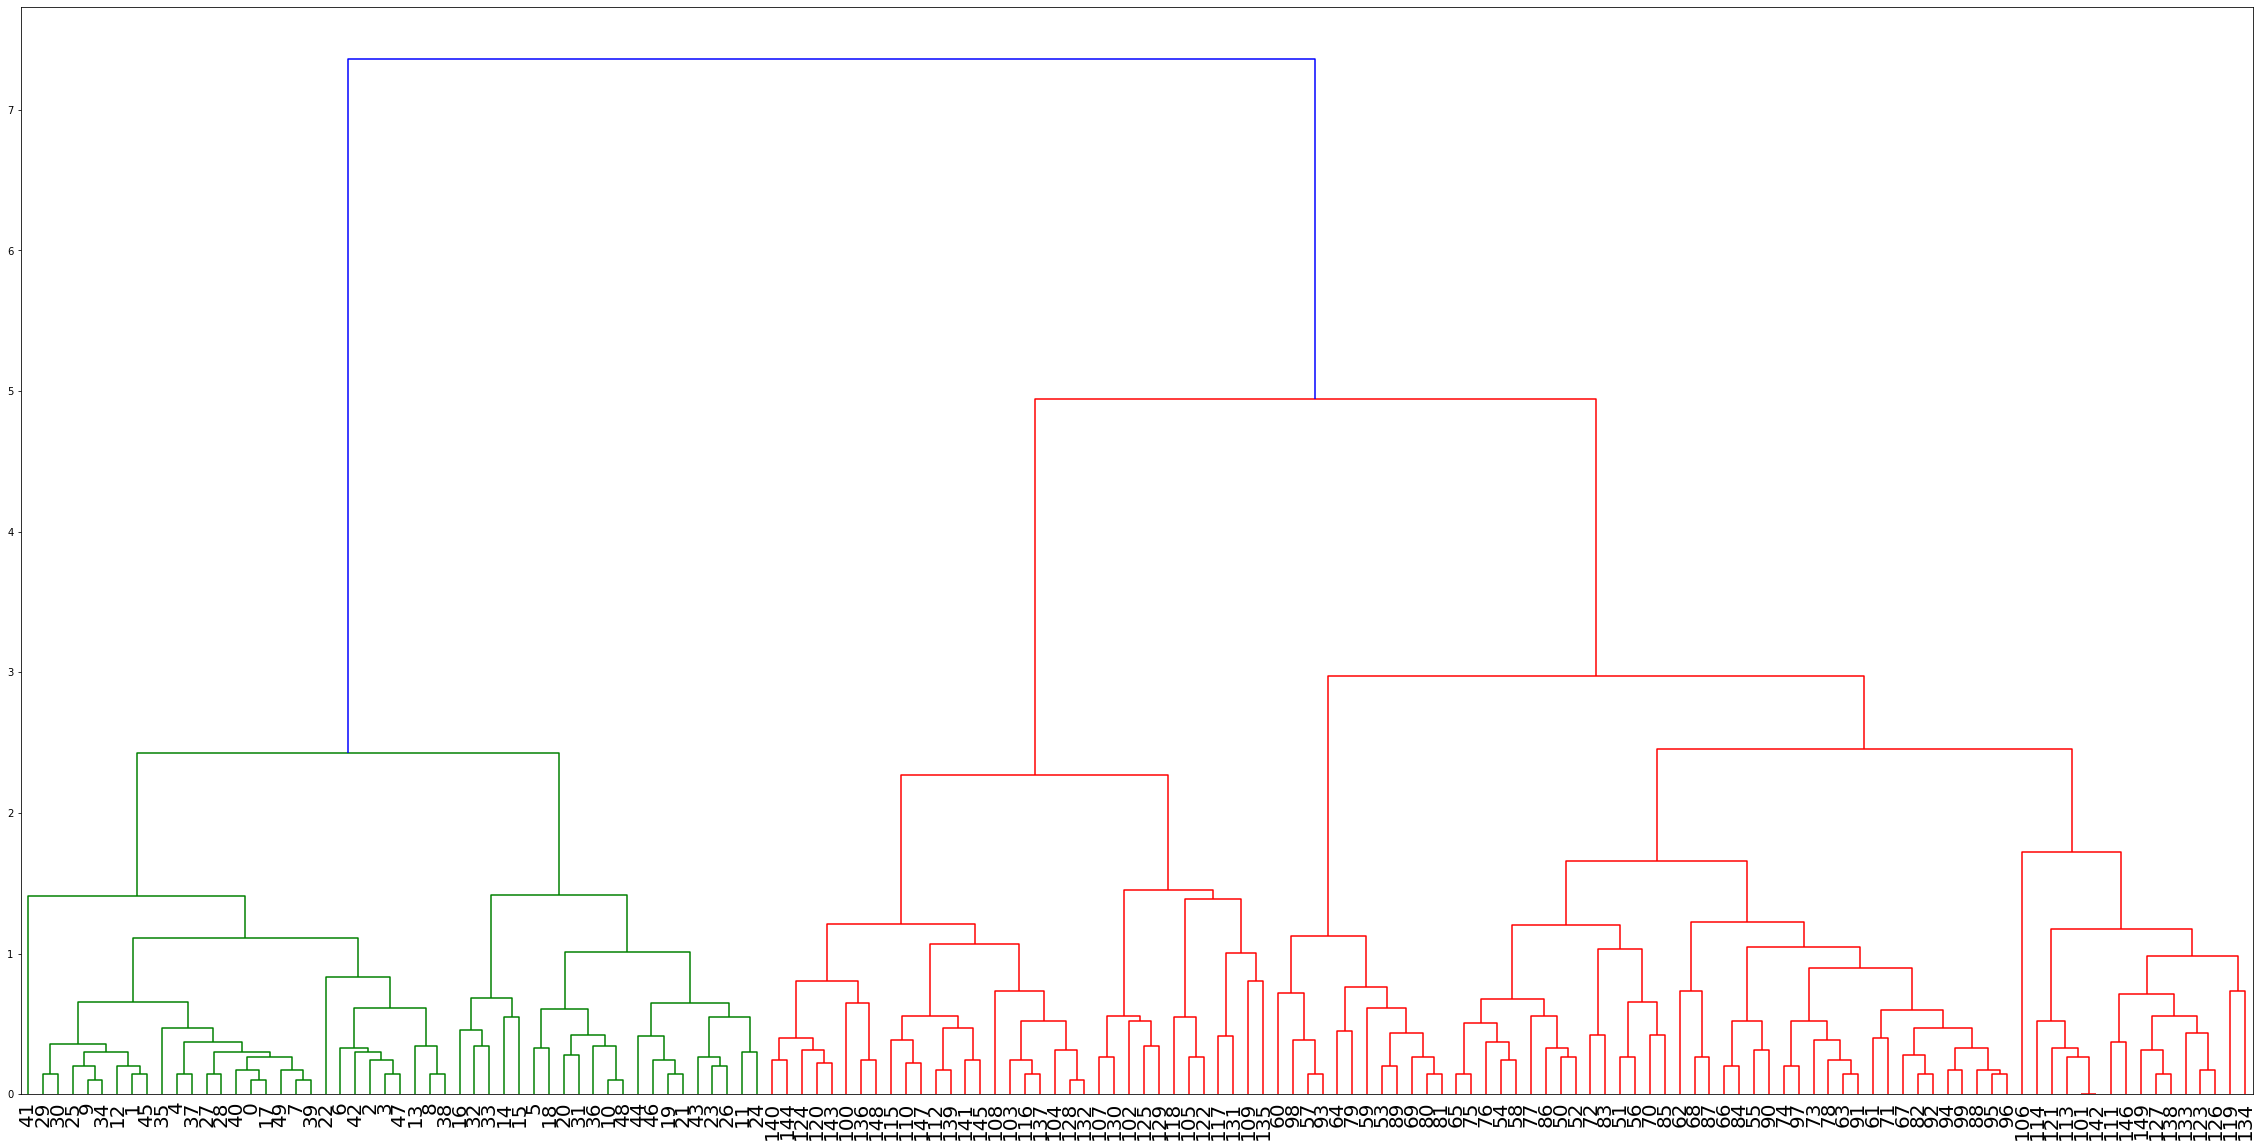

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Calculate the linkage: mergings
mergings = linkage(data,method='complete')

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(40,20))
dendrogram(mergings,
          #  labels = labels.values(columns=['labels']),
           leaf_rotation=90,
           leaf_font_size=20
)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

predict = pd.DataFrame(fcluster(mergings,3,criterion='distance'))
predict.columns=['predict']
ct = pd.crosstab(predict['predict'],labels['labels'])
print(ct)

labels    0   1   2
predict            
1        50   0   0
2         0   0  34
3         0  50  16


In [ ]:
import pandas as pd # dataset load
from sklearn.datasets import load_iris
# 계층적 군집 model
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import datasets
import seaborn as sns

1. dataset load

In [ ]:
iris = pd.read_csv("iris.csv")
iris.info()

,Sepal length,Sepal width,Petal length,Petal width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
cols = list(iris.columns)
iris_x = iris[cols[:4]]
iris_x.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
iris['Species'].value_counts() # 'Species' : y변수

virginica     50
setosa        50
versicolor    50
Name: Species, dtype: int64

2. y변수 수치화

In [ ]:
X, y = load_iris(return_X_y=True)

# 사이킷런 라이브러리에서 제공하는 데이터셋을 불러오면 범주값을 숫자로 받을 수 있음
y  # 0,1,2로 구성됨

labels = pd.DataFrame(y, columns = ['labels'])

# df = df + df
irisDF = pd.concat([iris_x, labels], axis = 1)
irisDF.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,labels
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
irisDF.tail()  # x변수들과 수치화된 y변수(labels)로 데이터프레임 만들어진 것을 확인

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,labels
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


 3. 계층적 군집분석 model

In [ ]:
clusters = linkage(y=irisDF, method='complete', metric='euclidean')
clusters
clusters.shape # (149, 4)

(149, 4)

'''
연결방식 
 1. 단순연결방식(single)
 2. 완전연결방식(complete)
 3. 평균연결방식(average)
'''

4. 덴드로그램 시각화 : 군집수 결정

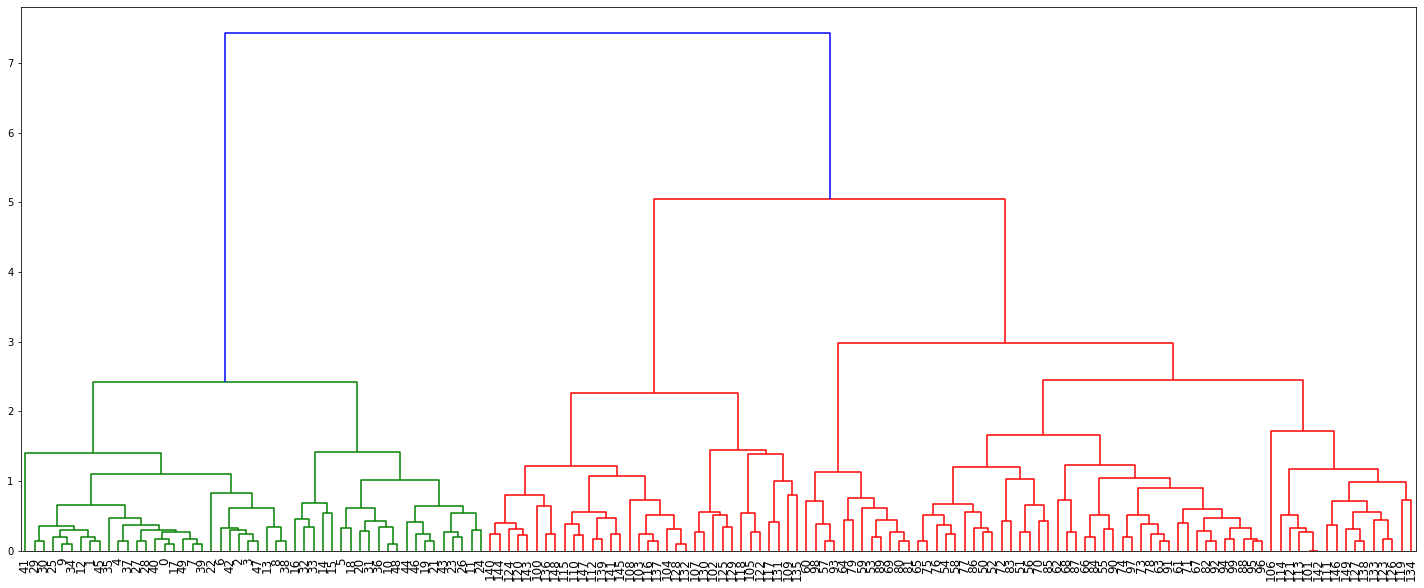

In [ ]:
import matplotlib.pyplot as plt
plt.figure( figsize = (25, 10) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
leaf_rotation=90 #: 글자 각도
leaf_font_size=20 #: 글자 사이즈
plt.show() 

5. 클러스터링(군집) 결과

In [ ]:
from scipy.cluster.hierarchy import fcluster # 지정한 클러스터 자르기

cut_tree = fcluster(clusters, t=3, criterion='distance')
cut_tree # prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2,
       2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3], dtype=int32)

In [ ]:
labels = irisDF['labels'] # 정답

df = pd.DataFrame({'pred':cut_tree, 'labels':labels})

con_mat = pd.crosstab(df['pred'], df['labels'])
'''
labels   0   1   2
pred              
1       50   0   0
2        0   0  34
3        0  50  16
'''

'\nlabels   0   1   2\npred              \n1       50   0   0\n2        0   0  34\n3        0  50  16\n'

In [ ]:
con_mat

labels,0,1,2
pred,,,
1,50,0,0
2,0,0,34
3,0,50,16


In [ ]:
# irisDF에 군집 예측치 추가
irisDF.head()
irisDF['cluster'] = cut_tree
irisDF.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,labels,cluster
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1


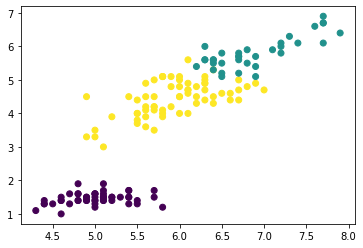

In [ ]:
# 클러스터 단위 산점도 시각화
plt.scatter(x=irisDF['Sepal.Length'], y=irisDF['Petal.Length'], c=irisDF['cluster'])

In [ ]:
# 클러스터 빈도수
irisDF['cluster'].value_counts()

3    66
1    50
2    34
Name: cluster, dtype: int64

In [ ]:
# 각 클러스터별 통계(평균)
cluster_g = irisDF.groupby('cluster')
cluster_g.mean()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,labels
cluster,,,,,
1,5.006000,3.428000,1.462000,0.246000,0.000000
2,6.888235,3.100000,5.805882,2.123529,2.000000
3,5.939394,2.754545,4.442424,1.445455,1.242424


# 비정형 데이터 http://databaser.net/moniwiki/wiki.php/DBSCAN

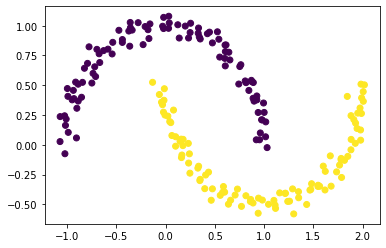

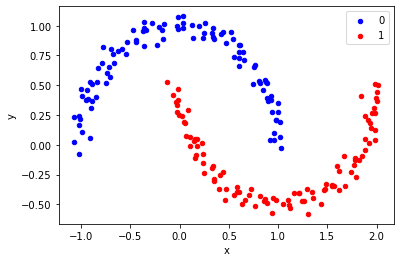

In [13]:
#two_moon 데이터 셋
from sklearn.datasets import make_moons
import pandas as pd
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

df = pd.DataFrame(X, columns=["x", "y"])
df["group"] = y
df[:5]

#import matplotlib.pyplot as plt
#plt.scatter(x=df.x, y=df.y, c=df.group)

#<scatter plot>: 여기부터
import matplotlib.pyplot as plt
plt.scatter(x=df.x, y=df.y, c=df.group)

fig, ax = plt.subplots()
colors = {1:'red', 0:'blue'}

grouped = df.groupby('group')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()
#</scatter plot>: 여기까지 한번에 실행

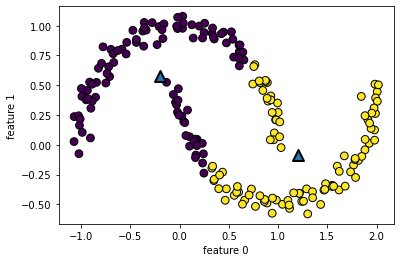

In [14]:
from sklearn.cluster import KMeans

x, y = make_moons(n_samples=200, noise=0.05, random_state=0) # 갯수, 퍼짐정도, 랜덤상태

kmeans = KMeans(n_clusters=2).fit(x) # 모델 객체 생성 및 학습

y_pred = kmeans.predict(x) # 모델 적용

plt.scatter(x[:, 0], x[:, 1], c=y_pred, s=60, edgecolors='black')# x, y, group, 점크기 60%, 테두리색 black, palette
#, cmap=mglearn.cm2) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], # x, y
            marker='^', s=120, linewidth=2, edgecolors='k')# marker,  점크기 120%, 두께, 테두리색, 색상 
            # , c=[mglearn.cm2(0), mglearn.cm2(1)]) 
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

Text(0, 0.5, 'y')

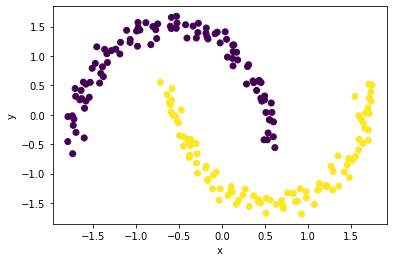

In [2]:
#표준화(평균=0, 분산=1)
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(df[["x", "y"]])
scaled_X = scale.transform(df[["x", "y"]])

df["scaled_x"] = scaled_X[:,0]
df["scaled_y"] = scaled_X[:,1]

#DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5) #기본값이다.
cluster = dbscan.fit_predict(scaled_X)
df["cluster"] = cluster

#clustering 결과 확인
plt.scatter(x=df.scaled_x, y=df.scaled_y, c=df.cluster)
plt.xlabel("x")
plt.ylabel("y")